# Problem setup

## Goal
Check if the **relationship** between input data and output of chiller has changed over time.

## Approach

This problem is generally known as **structural change** detection in econometrics. It is also related to **concept drift**, **change point detection** or simply **change detection** algorithms in CS and engineering.
See [this question](https://stats.stackexchange.com/questions/355920/how-to-test-if-the-process-that-generated-a-time-series-has-changed-over-time/358144#358144) I asked on an online forum for more information.

Here are a few possible approach to tackle this problem. In my opinion, none are satisfactory.
1. If given continuous sequence of data, most structural change algorithm maintains a set of test statistics obtained from the data stream and check at each point in time if the test statistics has changed significantly. 

2. Train two models, one for 2006 and another for 2008 data, and test if these two models are approximately the same.

3. Related to 1., check the errors (predictions - actual) has changed over time given the predictions from a model trained on year 2006 data. 

## Summary

1. We visualize the output of the chiller to visually check for any significant structure that we can exploit.
    
    - The output for each day pretty much similar to those of other days within close few months.
    - Individual outputs (ch1kw, ch2kw, ch3kw) changes between 2006 and 2008. If we have information pertaining to 
      these individual subsystems, we can do **multi-output** predictions to exploit the relationship between these 
      outputs rather than just predict their total.
    
2. We train a few algorithms/ML models to predict the output of the chiller system.
    - This tests how well regression algorithms can predict the output of chiller, i.e., we check if there is reason to believe the input data is related to the output.
      
3. We visualize the error of the models and observe that in general there is a change in the distribution of the error over time.
    
## Things to note

1. Almost (all) ML algorithms have hyperparameters that we need to set. **Different** hyperparameter settings can give the same training error and even validation error but very different test error.
What this says is that the same algorithm can give **very different** models but you won't know before hand because based on the training and validation data they all look the same. But they can give very different conclusions when given the test data.

2. If the total power is **noisy**, then it does **not** make sense to find a model that gives **zero** error because we will be fitting to the noise.

3. Extra knowledge about the structure of the problem can help improve the modeling process. For e.g., knowing when the system starts and shuts down each day (I recall paper says it shuts down around 7PM for Chinatown Point) can allow us to enforce condition that across days at the same period of time the predicted power should be close.

Furthermore, if domain knowledge about how these devices age over time (for e.g., efficiency is known to drops over time following a slow exponential curve), we can try to incorporate them into the model.

All these will enable the prediction to be more consistent and less likely to overfit to the spurious patterns in the data.

Even though Machine Learning has been marketed as a black box that is mostly automated, this is far from true in reality. There are many ways ML algorithms can overfit the data, sometimes in subtle ways, and less experienced users will be none the wiser that it has even happened.

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})

import GPyOpt 

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("ggplot")
%matplotlib inline

from IPython.display import display_html
def display_side_by_side(*args):
    """
    Taken from https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
    """
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

def plot_model_error(y, pred, figsize=(21, 10), title=None):
    index = y.index
    
    y = np.asarray(y).ravel()
    pred = np.asarray(pred).ravel()
    error = pred - y
    mean_error = (np.abs(error)).mean() # mean_absolute_error(y, pred) 
    
    y = pd.Series(y, index=index)
    pred = pd.Series(pred, index=index)
    error = pd.Series(error, index=index)
        
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=figsize)
    
    y.plot(color="green", label="Ground truth", ax=axes[0])
    pred.plot(color="blue", alpha=0.6, label="Prediction", ax=axes[0])
    error.plot(color="red", label="Error", ax=axes[1])
    
    axes[1].axhline(0, 0, 1, color="black", linestyle="--")    
    axes[0].tick_params(axis='both', which='major', labelsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=14)

    axes[0].legend()
    axes[1].legend()
    
    if title is None:
        title = "Mean error: {:.5f}".format(mean_error)
    else:
        title += " - Mean error: {:.5f}".format(mean_error)
        
    fig.suptitle(title, fontsize=20)
    fig.tight_layout();

def plot_cusum(y, pred, title=None, figsize=(21, 4), ax=None, **kwargs):    
    index = y.index
    
    error = np.asarray(pred.ravel()) - np.asarray(y.ravel())         
    error = pd.Series(error, index=index)
    cumsum = pd.Series(data=np.cumsum(error), name="CUSUM", index=index)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)    
    fig = ax.figure
    
    cumsum.plot(ax=ax, color="red")
    ax.axhline(0, 0, 1, color="black", linestyle="--")
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    if title is not None:
        ax.set_title(title, fontsize=20)
    ax.legend()
    fig.tight_layout()


import matplotlib.ticker as ticker
def plot_outputs(df, figsize=(18, 18), title=None):    
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=figsize)
    
    total = df.ch1kw + df.ch2kw + df.ch3kw
    max_output = total.max()
    for i, ax in enumerate(axes[:3], 1): # in range(3):
        column = "ch{}kw".format(i)
        df[column].plot(ax=ax, title="ch{}kw".format(i), label=column)        
        (df["ch{}_status".format(i)] * max_output).plot(ax=ax, alpha=0.3)
        ax.legend()
        
    total.plot(ax=axes[3], title="Total", label="Total output")
    axes[3].axhline(total.mean(), 0, 1, linestyle="--", color="black", label="Mean")
            
    tick_spacing = 50
    axes[3].yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))    
        
#     start, end = axes[3].get_xlim()
#     stepsize = 50
    #     axes[3].yaxis.set_ticks(np.arange(start, end, stepsize))

    
    axes[3].legend()
        
    if title is not None:
        fig.suptitle(title)    
        
    fig.tight_layout()

## Global parameters

In [61]:
N_TIMESERIES_SPLITS = 5
BO_RAND_STATE = 777
SCORE_TYPE = "neg_mean_absolute_error"

## Get data 

Note that the data have been preprocessed earlier in another Jupyter notebook to remove entries with missing data (indicated as "\\N" in csv file).

In [62]:
df1 = pd.read_csv("../data/insead_2016_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")
df2 = pd.read_csv("../data/insead_2018_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")

In [63]:
display_side_by_side(df1.head(2), df2.head(2))

,chwshdr,cwrhdr,cwshdr,cwsfhdr,ch1kw,ch2kw,ch3kw,loadsys,chwsfhdr,ch1_status,ch2_status,ch3_status,totalkw
timestamp,,,,,,,,,,,,,
2016-02-01 00:00:00,0.00000,30.4664,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0.000
2016-02-01 00:01:00,8.46289,30.3218,27.143,536.522,0.844,0.856,82.944,113.924,407.278,0,0,1,84.644
,chwshdr,cwrhdr,cwshdr,cwsfhdr,ch1kw,ch2kw,ch3kw,loadsys,chwsfhdr,ch1_status,ch2_status,ch3_status,totalkw
timestamp,,,,,,,,,,,,,
2018-04-01 00:00:00,0.0000,0.0000,0.0000,576.223,42.24,0.848,0,95.6832,486.972,1,0,0,43.088
2018-04-01 00:01:00,10.7674,28.8237,26.3996,579.979,42.24,0.852,0,96.2943,486.091,1,0,0,43.092


In [64]:
df1.shape, df2.shape

((81623, 13), (53147, 13))

## Separate into feature and target

In [83]:
features = [
"chwshdr",
"cwrhdr",
"cwshdr",
"cwsfhdr",
"loadsys",
"chwsfhdr", 

# Cannot use this as it is a source of data leakage
# "ch1_status",
# "ch2_status",
# "ch3_status",
]

status_features = [
"ch1_status",
"ch2_status",
"ch3_status"    
]

target = ["totalkw"]

In [84]:
# Assign features and targets
y1 = df1.totalkw
y2 = df2.totalkw
X1 = df1[features]
X2 = df2[features]

## Split into train and test data

Let's count the number of data points we have per week of each year.

In [86]:
# Number of days in each week in the two datasets
display_side_by_side(df1.groupby(df1.index.week).size().to_frame(name="Number of examples per week (2006)"),
                     df2.groupby(df2.index.week).size().to_frame(name="Number of examples per week (2008)"))

,Number of examples per week (2006)
timestamp,
5,10065
6,10046
7,10062
8,6247
9,9710
10,9746
11,9930
12,10066
13,5751


Then we split each dataset into two parts. The first contain the **first $N$ weeks**, and the second contain the rest.
We also show the number of examples in each resulting dataset.

In [87]:
N_TRAIN_WEEKS = 4  # First few weeks are used for training, rest for test.

X1_train = X1.iloc[X1.index.week < X1.index.week[0] + N_TRAIN_WEEKS]
X1_test = X1.iloc[X1.index.week > X1_train.index.week[-1]]

y1_train = y1.iloc[X1.index.week < X1.index.week[0] + N_TRAIN_WEEKS]
y1_test = y1.iloc[X1.index.week > X1_train.index.week[-1]]

X2_train = X2.iloc[X2.index.week < X2.index.week[0] + N_TRAIN_WEEKS]
X2_test = X2.iloc[X2.index.week > X2_train.index.week[-1]]

y2_train = y2.iloc[X2.index.week < X2.index.week[0] + N_TRAIN_WEEKS]
y2_test = y2.iloc[X2.index.week > X2_train.index.week[-1]]

dataset_counts = pd.DataFrame(((name, len(x))
     for x, name in zip((X1_train, X1_test, X2_train,
                         X2_test), ("Train (2006)", "Test (2006)",
                                    "Train (2008)", "Test (2008)"))))
dataset_counts.set_index(0).T

,Train (2006),Test (2006),Train (2008),Test (2008)
1,36420,45203,31603,21544


## Visualize output of chiller

Let's visualize the output for the dataset from year **2006**.

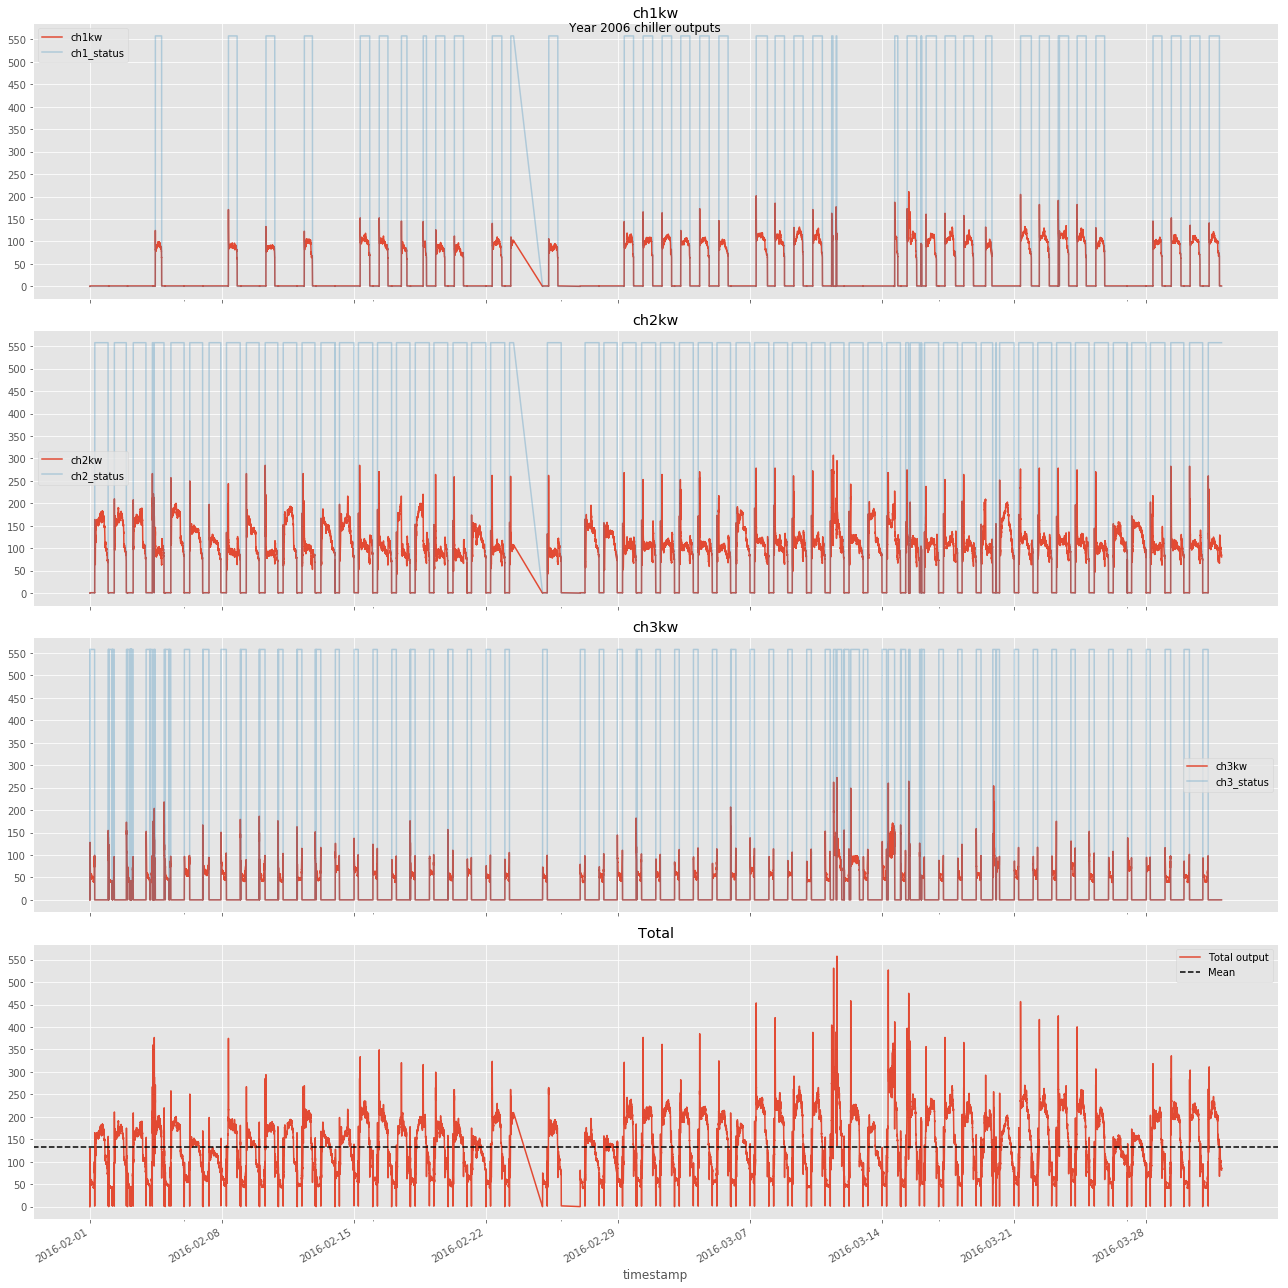

In [144]:
plot_outputs(df1, title="Year 2006 chiller outputs")

Next, we visualize the output for the dataset from year **2008**.

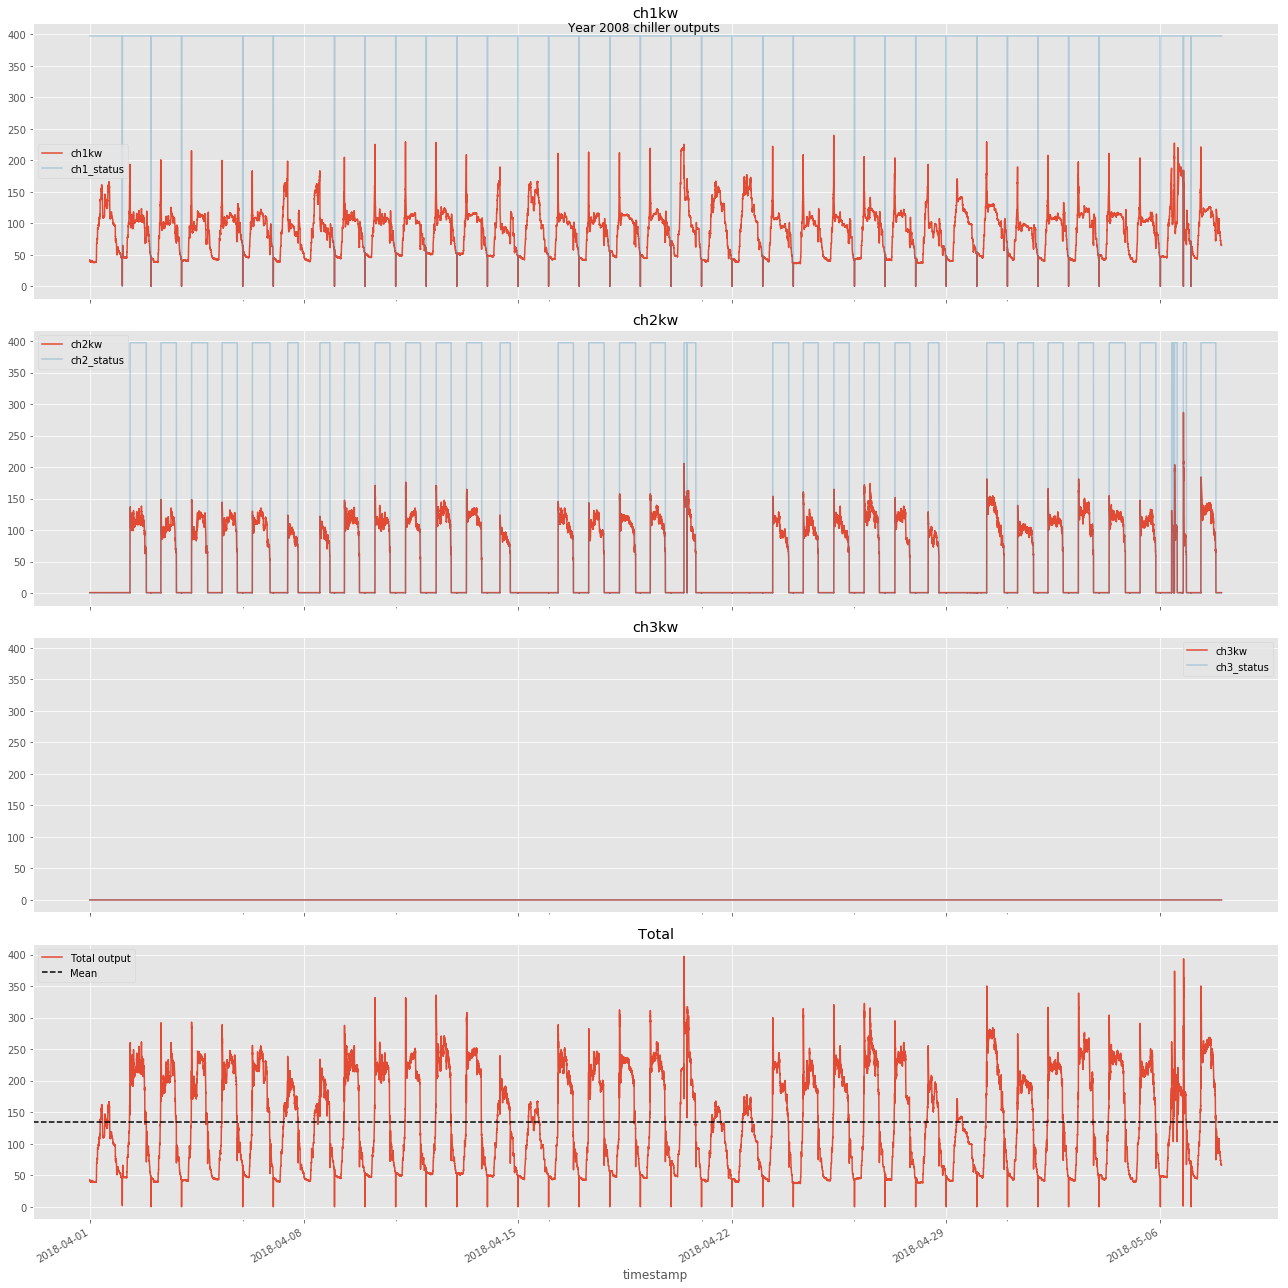

In [145]:
plot_outputs(df2, title="Year 2008 chiller outputs")

It is worth noting that pattern does not only change in the total, but also in the individual outputs "ch1kw", "ch2kw" and "ch3kw".

The mean total power is roughly the same (slightly less than 150) for both years, but the **peak daily total power** seems to be much higher in 2006's data. 

Could this be due to
1. Aging equipment,
2. data being collected on different month and year (temperature different) and/or
3. changes in system configuration?

Note: this [weather map](http://www.weather.gov.sg/climate-detailed-view/) of Singapore suggests that it was **much hotter in April 2008 than February 2006**.

There is a chunk of consecutive missing data in 2006. There should also be some missing data in 2008, but these are sporadic, and is less of a problem. In general this is a problem only for models that model the data as sequence. 

Lastly note that the range of the x-axis for the 2006 and 2008 datasets are different when trying to compare the plots for these two years.

---

# Build models

Here we train various models on data from the first few weeks of the dataset from year **2006** to predict the total output of the chiller. Each of these model represents the relationship between the given inputs and outputs in year 2006. 

We will use these models to predict the output given the data in year 2006 (later part) **and** 2008 and check if the error of prediction follows a different pattern for the two years.

Intuitively, we are checking for the following cases

1. Errors in 2006 and 2008 do not differ by much, i.e., chiller has not changed/aged.
2. Predictions generally **larger** than recorded output (over prediction).
3. Predictions generally **smaller** than recorded output (under prediction).
4. Sporadic large errors (anomalies).

The hyperparameters are selected using [Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) to maximize the performance using **timeseries-based cross validation**.

Finally, we test the the models on both the training and test datasets.

**Note**:
Models have hyperparameters and different hyperparameters may result in different models with same training error but different test error. Therefore this approach in general can be sensitive to how the hyperparameters are set and **can lead to different conclusion** about the state of the chiller. This is why it was mentioned earlier that this approach might not be a good one.

## Linear (actually ridge) regression model

This is linear regression with $L_2$ regularization, so it is technically ridge regression, but we will refer to it as linear regression.

We want to test how well a simple linear regression model can predict the output given the input data. We use Bayesian Optimization to find the best set of hyperparameters that minimizes the cross validated mean absolute error (MAE).

Best alpha param: 0.001


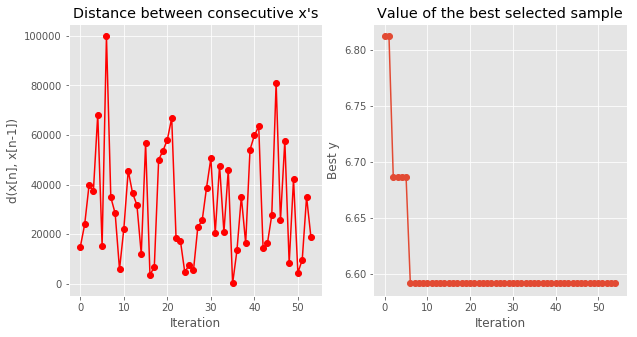

In [114]:
# Set up Bayesian Optimization
import functools

def f_lr(params, X, y, cv):
    params = params[0]
    score = -cross_val_score(Ridge(alpha=params[0]),                              
                             X, y,
                             cv=cv,
                             scoring=SCORE_TYPE).mean()
    return np.array(score)

np.random.seed(BO_RAND_STATE)
f = functools.partial(f_lr, X=X1_train, y=y1_train, cv=TimeSeriesSplit(n_splits=N_TIMESERIES_SPLITS))
lr_domains = [{'name': 'alpha', 'type': 'continuous', 'domain': (1e-3, 1e5)}]
optimizer = GPyOpt.methods.BayesianOptimization(f=f, 
                                                domain=lr_domains,
                                                acquisition_type='EI', # "LCB" works better
                                                acquisition_par=0.2,
                                                exact_feval=False)
optimizer.run_optimization(max_iter=50)
print("Best alpha param: {}".format(optimizer.x_opt[0]))

optimizer.plot_convergence()
# optimizer.plot_acquisition()

### Plot errors

Note that 2006 (early part) is also the **training** data.

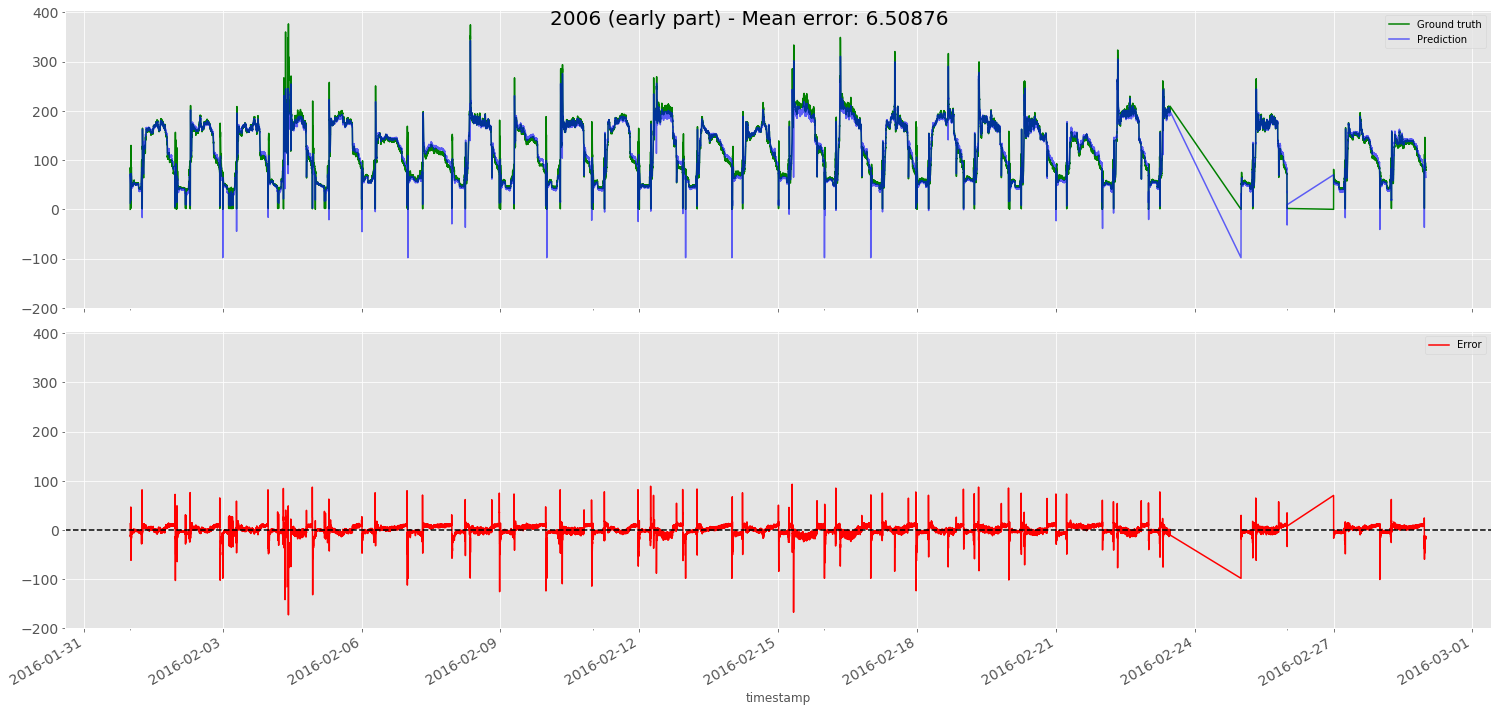

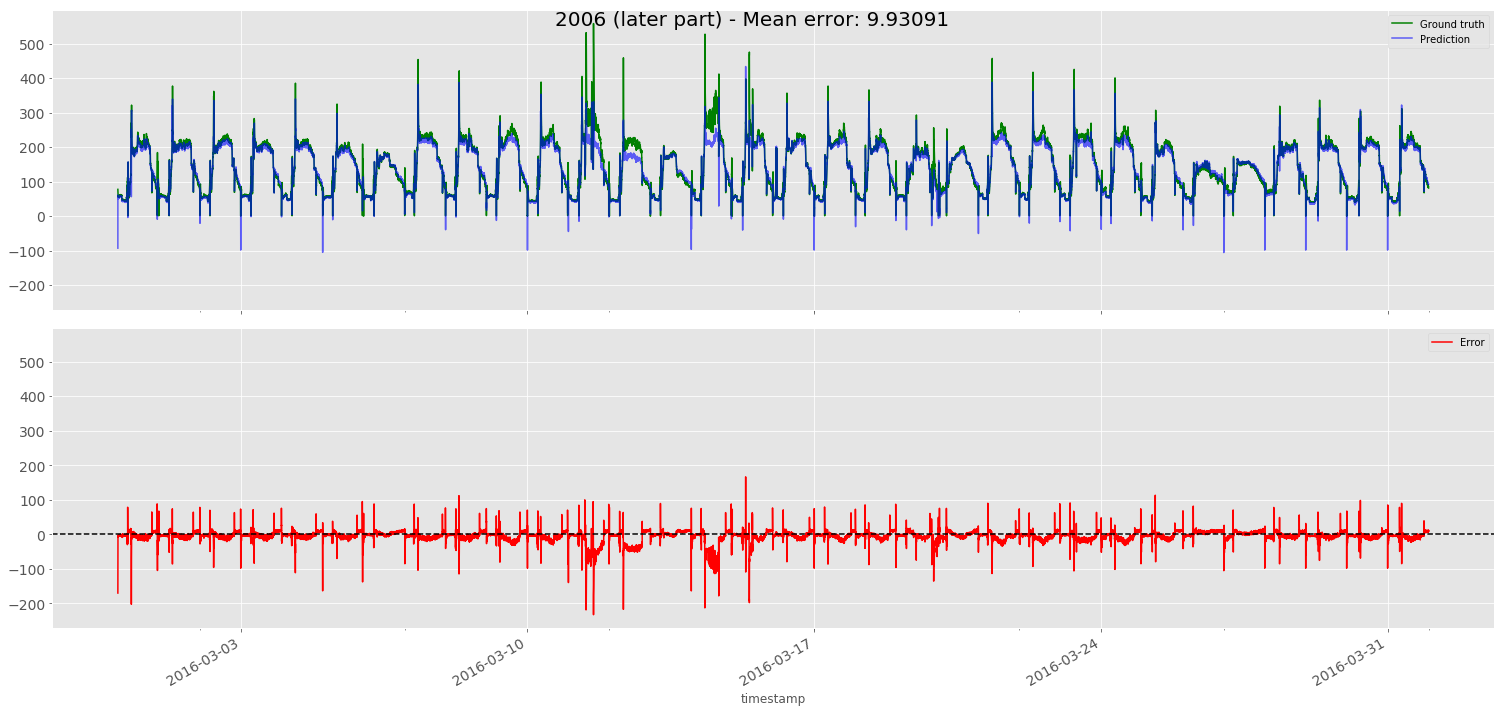

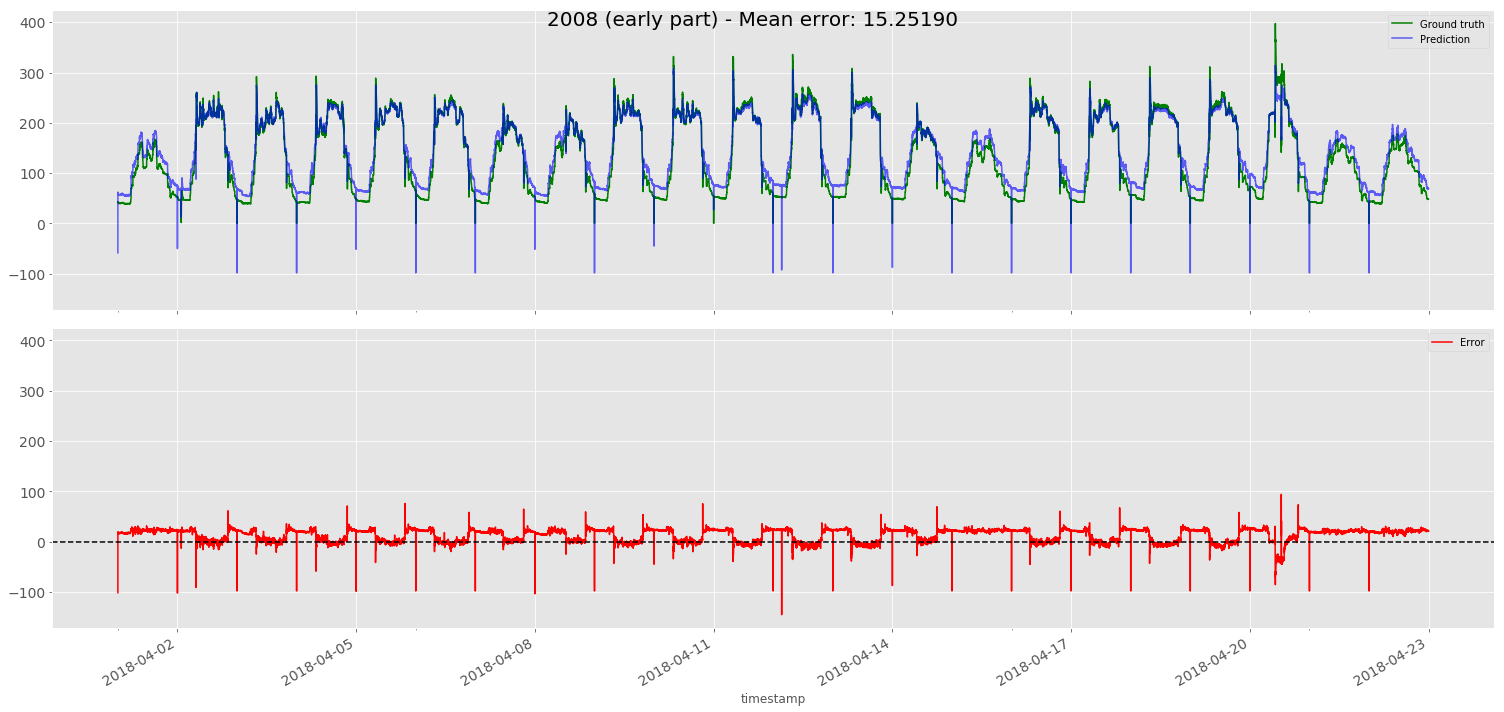

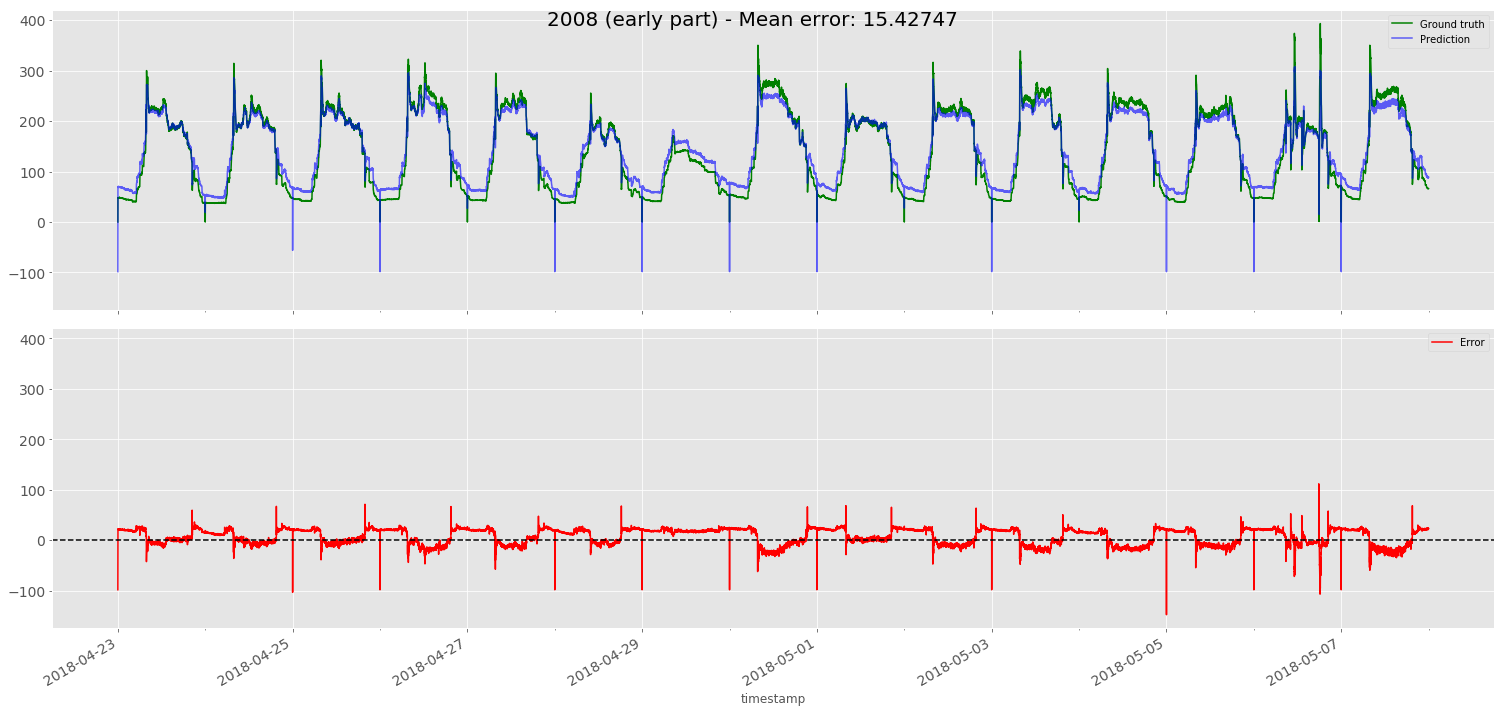

In [118]:
lr = Ridge(alpha=optimizer.x_opt[0])
lr.fit(X1_train, y1_train)

y1_train_pred = lr.predict(X1_train)
y2_train_pred = lr.predict(X2_train)

y1_test_pred = lr.predict(X1_test)
y2_test_pred = lr.predict(X2_test)


plot_model_error(y1_train, y1_train_pred, title="2006 (early part)")
plot_model_error(y1_test, y1_test_pred, title="2006 (later part)")

plot_model_error(y2_train, y2_train_pred, title="2008 (early part)")
plot_model_error(y2_test, y2_test_pred, title="2008 (early part)")

Prediction by model is in <font color="blue">**blue**</font>, actual is <font color="green">**green**</font>. Their difference, i.e, error = prediction - actual, is in <font color="red">**red**</font> at the bottom.

We see that this model in general **under predicts** for the year 2006 test data (top) and **over predicts** for both parts of the year 2008 data (middle 2 and bottom 2 figures).

However, **note** that there seems to be consistent sharp increase and decrease at certain points in time. Further analysis shows that these points corresponds to near midnight, early evening (6 to 8 PM), and near noon time (12 to 2PM). These times appear to be the startup/shutdown or some repair times. 

The system is not modeling these cases well, and having extra information (i.e., extra inputs or knowledge from logs) that we can use to build more sophisticated models will help in reducing errors in such cases.

### Plot cumulative error

Here we plot the cumulative error over time. This is just the cumulative sum of the error plots (red lines) above. In general, **if there is no systemic over/under prediction, the cumulative error should even out over the long run so it should stay near 0**. This is essentially the main idea behind some structural change algorithms.

Target data test error: 9.92222


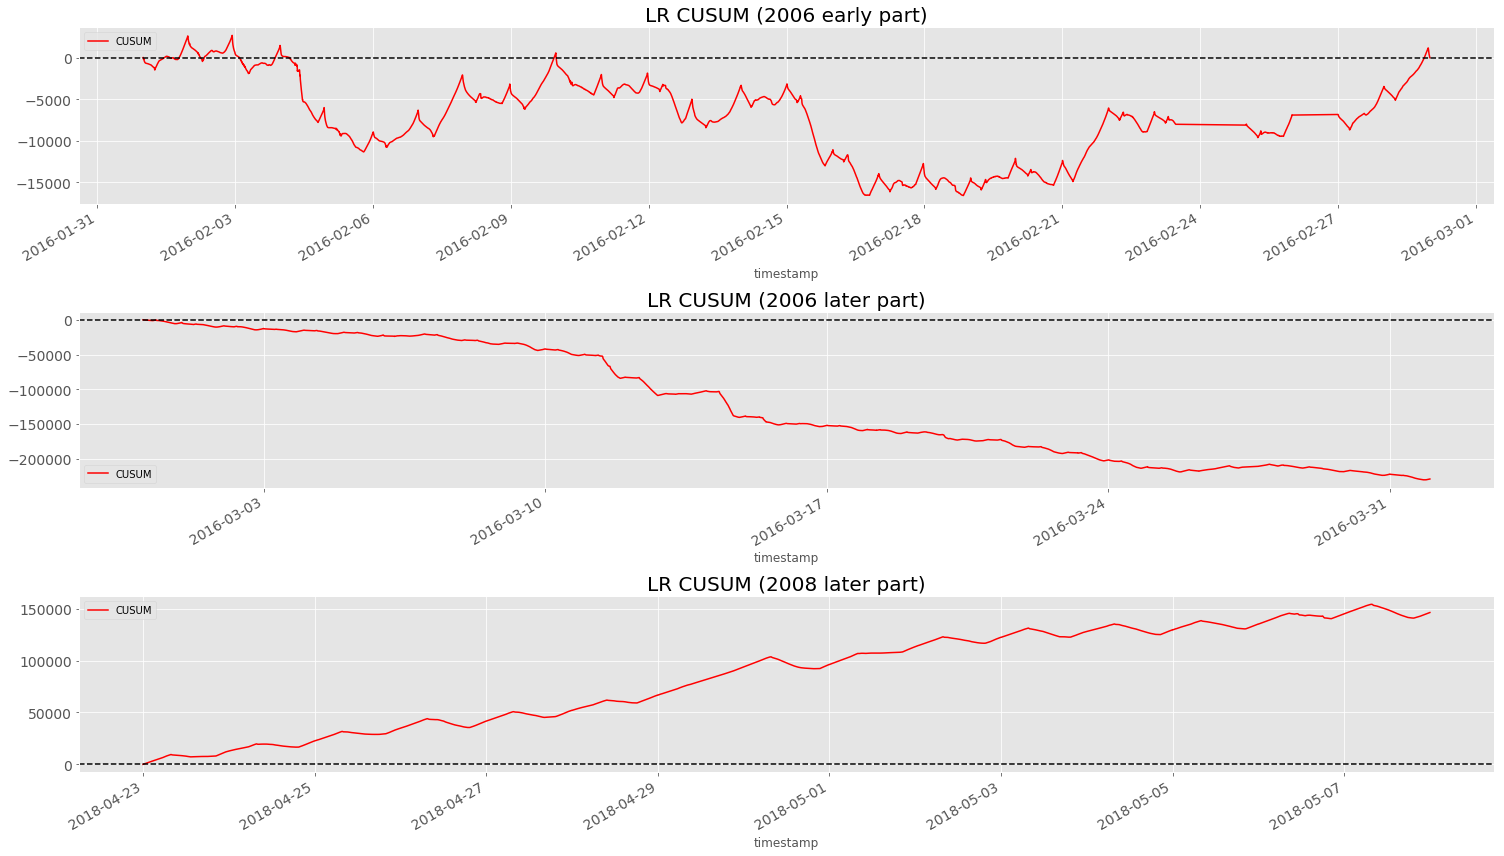

In [107]:
fig, axes = plt.subplots(3, 1, figsize=(21, 12))
plot_cusum(y1_train, y1_train_pred, "LR CUSUM (2006 early part)", ax=axes[0])
plot_cusum(y1_test, y1_test_pred, "LR CUSUM (2006 later part)", ax=axes[1])
plot_cusum(y2_test, y2_test_pred, "LR CUSUM (2008 later part)", ax=axes[2])
print("Target data test error: {:.5f}".format(mean_absolute_error(y2_test, y2_pred)))

We see that when tested on the **training** data, the cumulative error eventually goes back to 0 (dotted line), although it seems to be under predicting in general.

When tested on data **not** used in training, the model is clearly **under predicting** for the later part of year 2006 data and **over predicting** for both parts of year 2008 data. You can verify this from the error plots in figures earlier.

**What this means** is that even for data from the same year, this model will lead to a conclusion that there are changes in the system. This is clearly a problem.

## XGBoost model

Here we perform the same experiments as above but with the popular XGBoost regressor. This is a tree-based regressor. In general, it is a "high capacity" model than linear regression and should give better results than linear regression.

Best param: [6.0e-01 1.0e-03 1.2e+01]


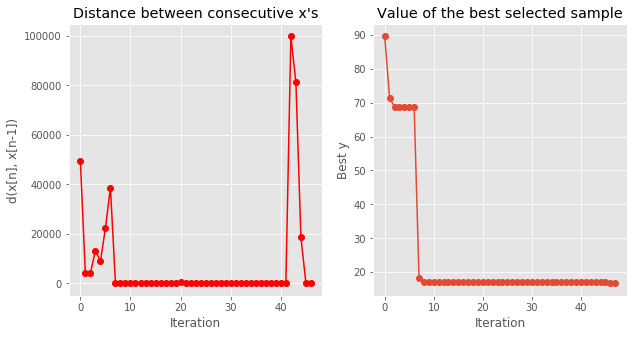

In [120]:
from xgboost import XGBRegressor

xgb_domains = [
#     {
#         "name": "learning_rate",
#         "type": "continuous",
#         "domain": (1e-5, 1)
#     },
#     {
#         'name': 'gamma',
#         'type': 'continuous',
#         'domain': (0, 5)
#     },
    {
        "name": "colsample_bytree",
        "type": "continuous",
        "domain": (0.3, 0.6)
    },
    {
        "name": "reg_lambda",
        "type": "continuous",
        "domain": (1e-3, 1e5)
    },
#     {
#         "name": "reg_alpha",
#         "type": "continuous",
#         "domain": (0, 1e3)
#     },
    {
        "name": "max_depth",
        "type": "discrete",
        "domain": (5, 12)
    },
#     {
#         "name": "n_estimators",
#         "type": "discrete",
#         "domain": (100, 500)
#     }
]

def f_xgb(params, X, y, cv, random_state):
    params = params[0]
    score = -cross_val_score(XGBRegressor(
                                          n_estimators=200,
                                          max_depth=int(params[2]),
#                                           learning_rate=params[0],                                          
#                                           gamma=params[1],
                                          learning_rate=0.01,
                                          colsample_bytree=params[0],
                                          reg_lambda=params[1],
#                                           reg_alpha=params[4],
                                          random_state=random_state,
                                          n_jobs=4
                                          ),
                             X, y,
                             cv=cv,
                             scoring=SCORE_TYPE).mean()
    return np.array(score)

np.random.seed(BO_RAND_STATE)
random_state = 1234
f = functools.partial(f_xgb, X=X1_train, y=y1_train, 
                      cv=TimeSeriesSplit(n_splits=N_TIMESERIES_SPLITS),
                      random_state=random_state)

optimizer = GPyOpt.methods.BayesianOptimization(f=f, 
                                                domain=xgb_domains,
                                                acquisition_type='EI', # "LCB" sometimes work better
#                                                 model_type="GP",
                                                acquisition_par=0.2,
                                                exact_feval=False)


optimizer.run_optimization(max_iter=100)
print("Best param: {}".format(optimizer.x_opt))

optimizer.plot_convergence()

In [121]:
params = optimizer.x_opt
xgb = XGBRegressor(n_estimators=200,
                   max_depth=int(params[2]),
                   learning_rate=0.1,                                      
                   colsample_bytree=params[0],
                   reg_lambda=params[1],
#                    reg_alpha=params[4],
                   random_state=random_state,
                   n_jobs=4)

xgb.fit(X1_train, y1_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=1234,
       reg_alpha=0, reg_lambda=0.001000000000000334, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

### Plot errors

Note that 2006 (early part) is also the **training** data.

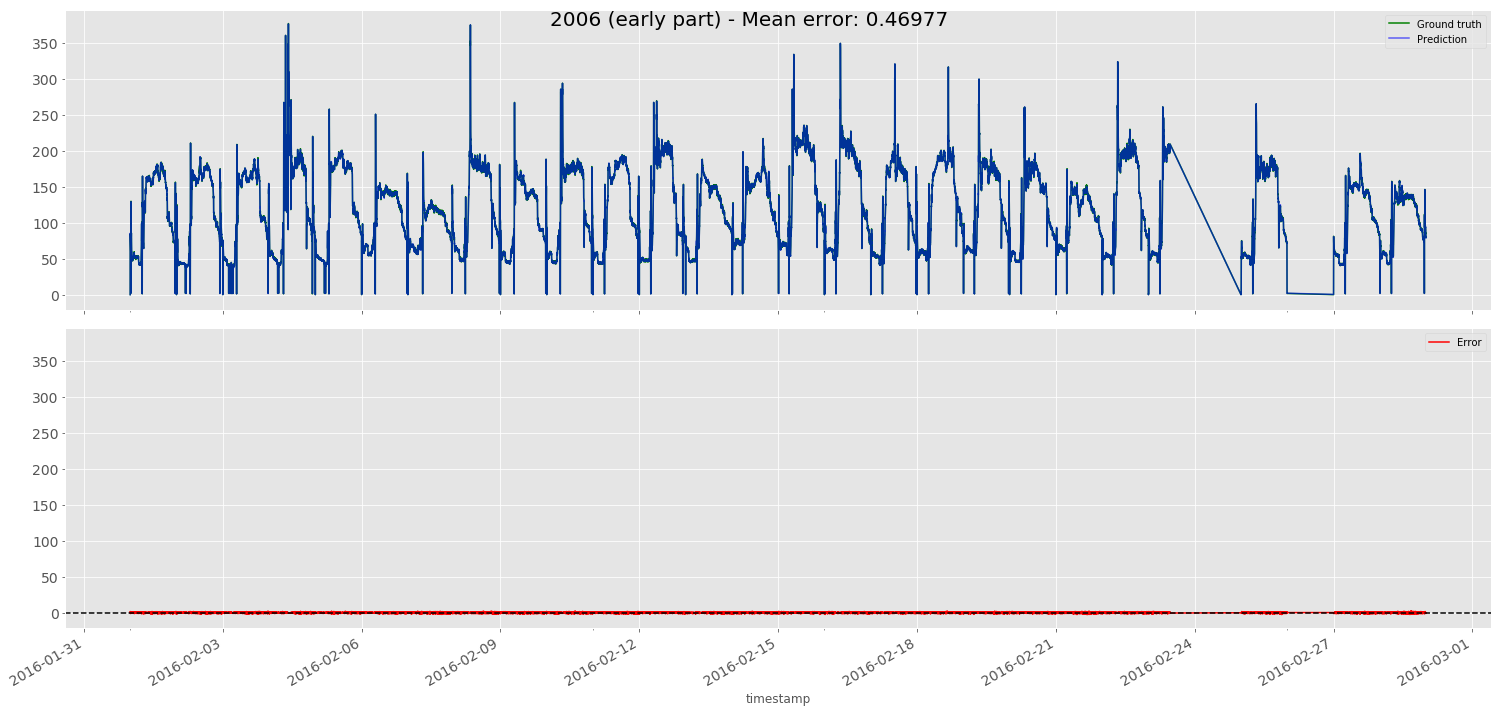

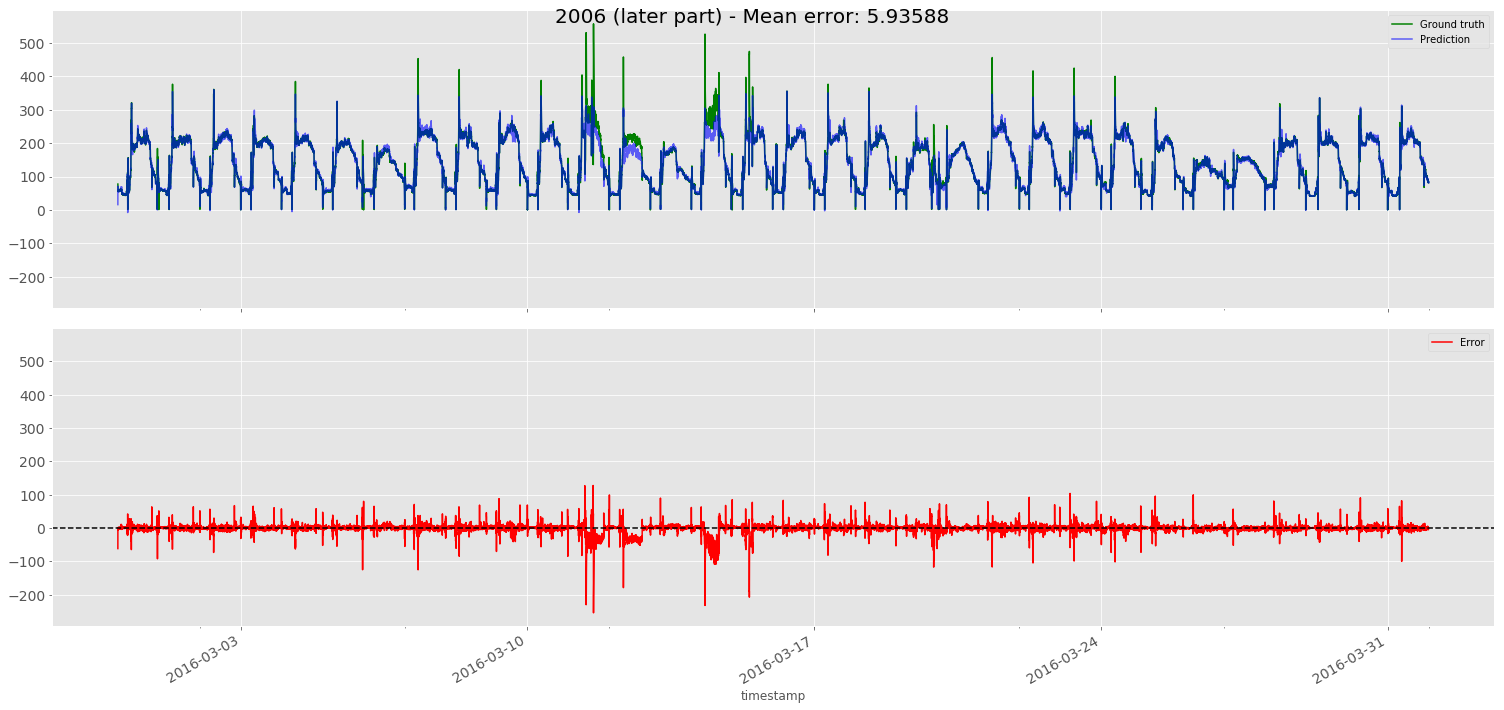

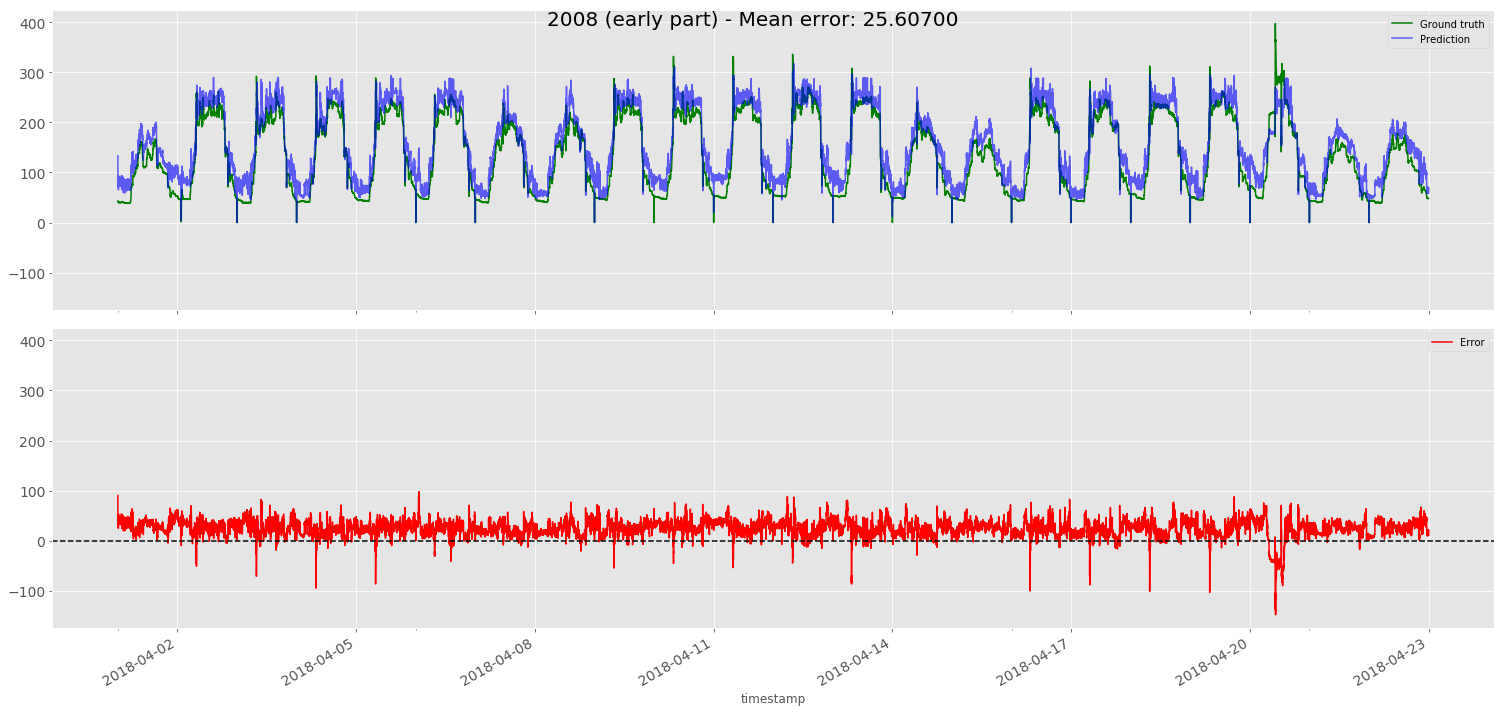

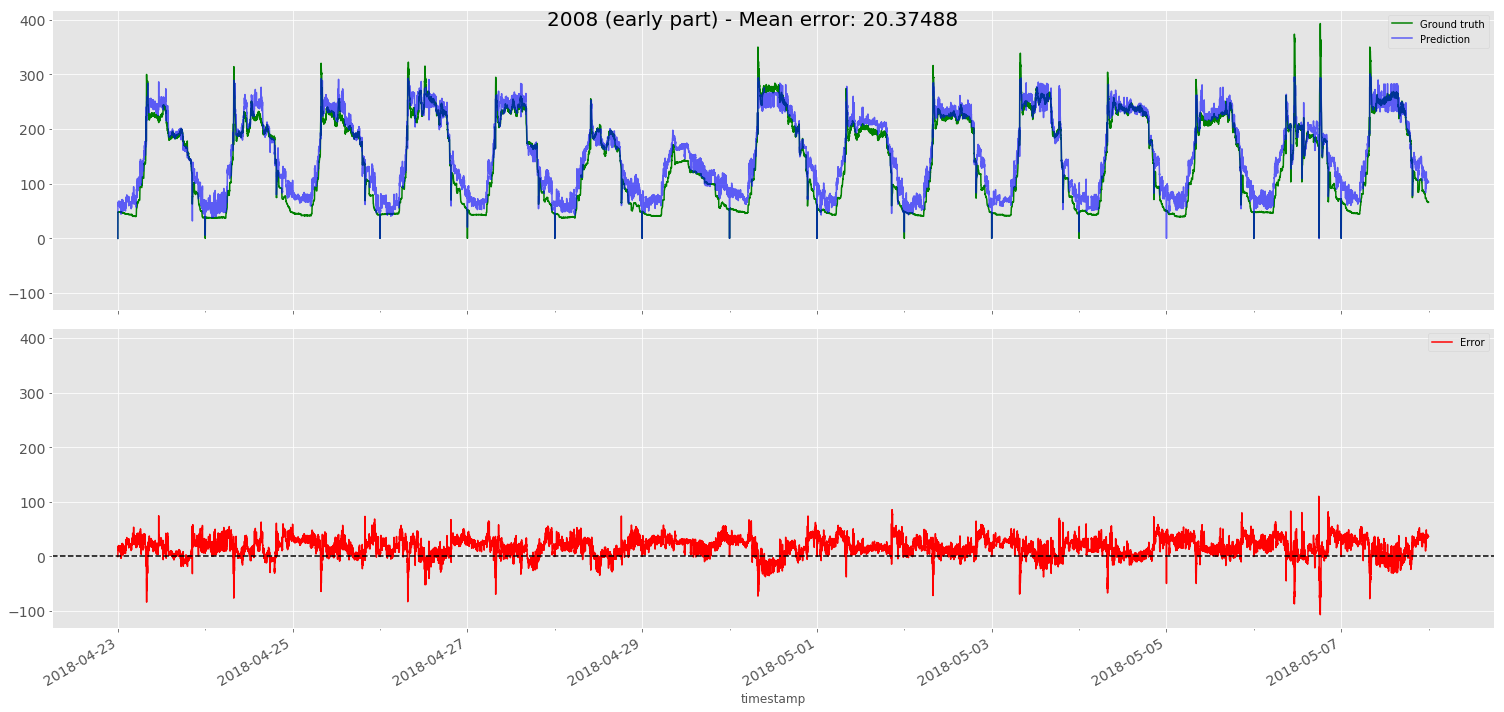

In [124]:
y1_train_pred = xgb.predict(X1_train)
y2_train_pred = xgb.predict(X2_train)
y1_test_pred = xgb.predict(X1_test)
y2_test_pred = xgb.predict(X2_test)

plot_model_error(y1_train, y1_train_pred, title="2006 (early part)")
plot_model_error(y1_test, y1_test_pred, title="2006 (later part)")
plot_model_error(y2_train, y2_train_pred, title="2008 (early part)")
plot_model_error(y2_test, y2_test_pred, title="2008 (early part)")

### Plot cumulative error

Target data test error: 9.92222


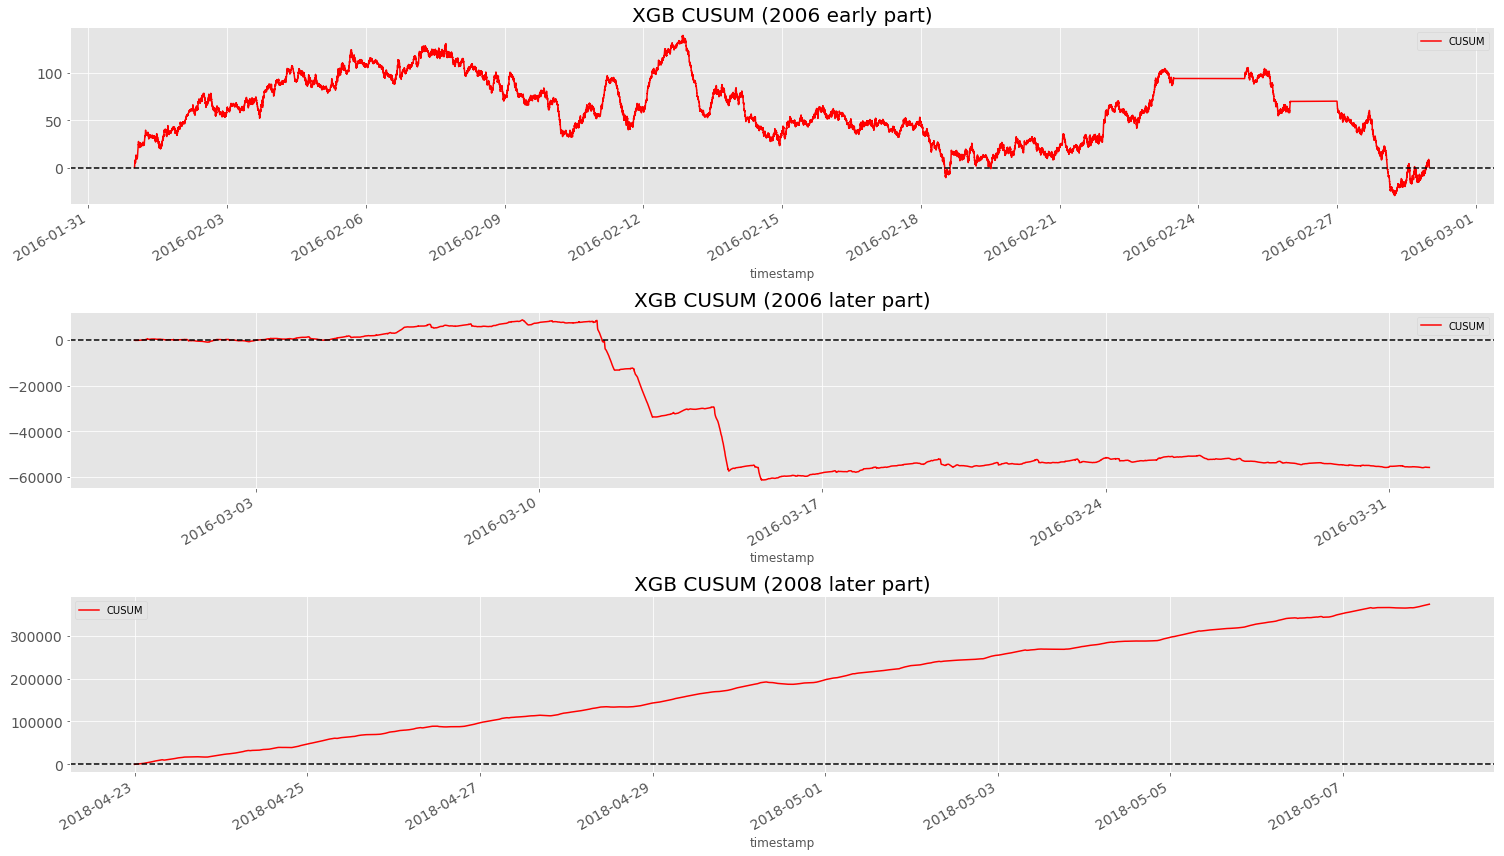

In [125]:
fig, axes = plt.subplots(3, 1, figsize=(21, 12))
plot_cusum(y1_train, y1_train_pred, "XGB CUSUM (2006 early part)", ax=axes[0])
plot_cusum(y1_test, y1_test_pred, "XGB CUSUM (2006 later part)", ax=axes[1])
plot_cusum(y2_test, y2_test_pred, "XGB CUSUM (2008 later part)", ax=axes[2])
print("Target data test error: {:.5f}".format(mean_absolute_error(y2_test, y2_pred)))

Interestingly, we see that this XGBoost model also **under predict** the output for the later part of 2006 and **over predict** for the year 2008.

Could the over prediction be a sign that for similar sensor input, the 2008 data corresponding output is **smaller because the system has gotten less efficient?**

## GP model

Let's try another sophisticated probabilistic model - [Gaussian Processes](https://sheffieldml.github.io/GPy/). This model is interesting in that it can be extended to handle multi-outputs as well as incorporate time information.

However, the GP model has problem scaling up to large datasets so we will 

In [128]:
import GPy

from GPy.models import SparseGPRegression

N_TRAIN = 20000 # X1_train.shape[0]
n_inducing = 1000

dim = X1_train.shape[1]
k_matern32 = GPy.kern.Matern32(input_dim=dim, variance=10.0, lengthscale=2000)
k = k_matern32
gpr = SparseGPRegression(X=X1_train.values[:N_TRAIN], 
                         Y=y1_train.values[:N_TRAIN].reshape(-1, 1),
                         kernel=k,
                         num_inducing=n_inducing)

In [62]:
# gpr.optimize_restarts(num_restarts=5)
# This will take a very long time for large datasets (n ~ 10000)
gpr.optimize()

### Plot errors

Note that 2006 (early part) is also the **training** data.

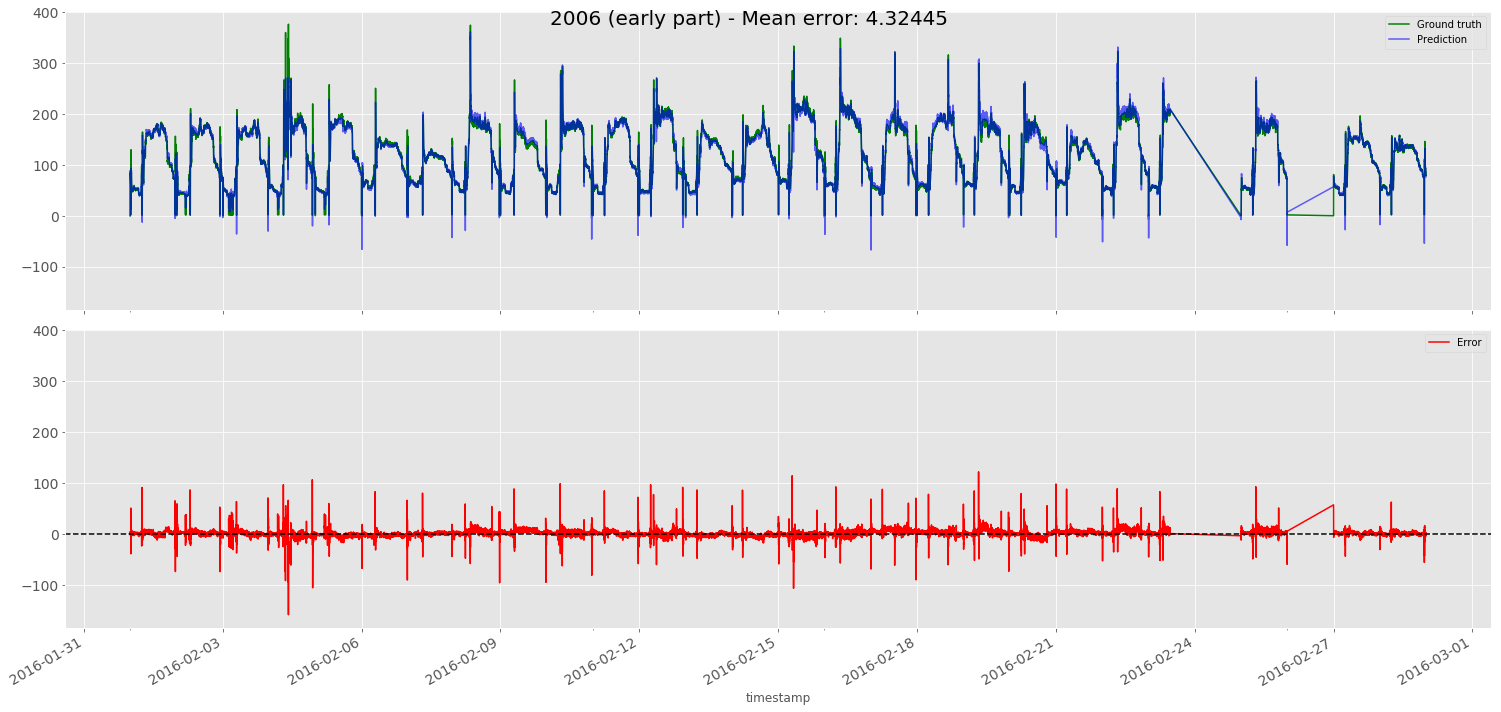

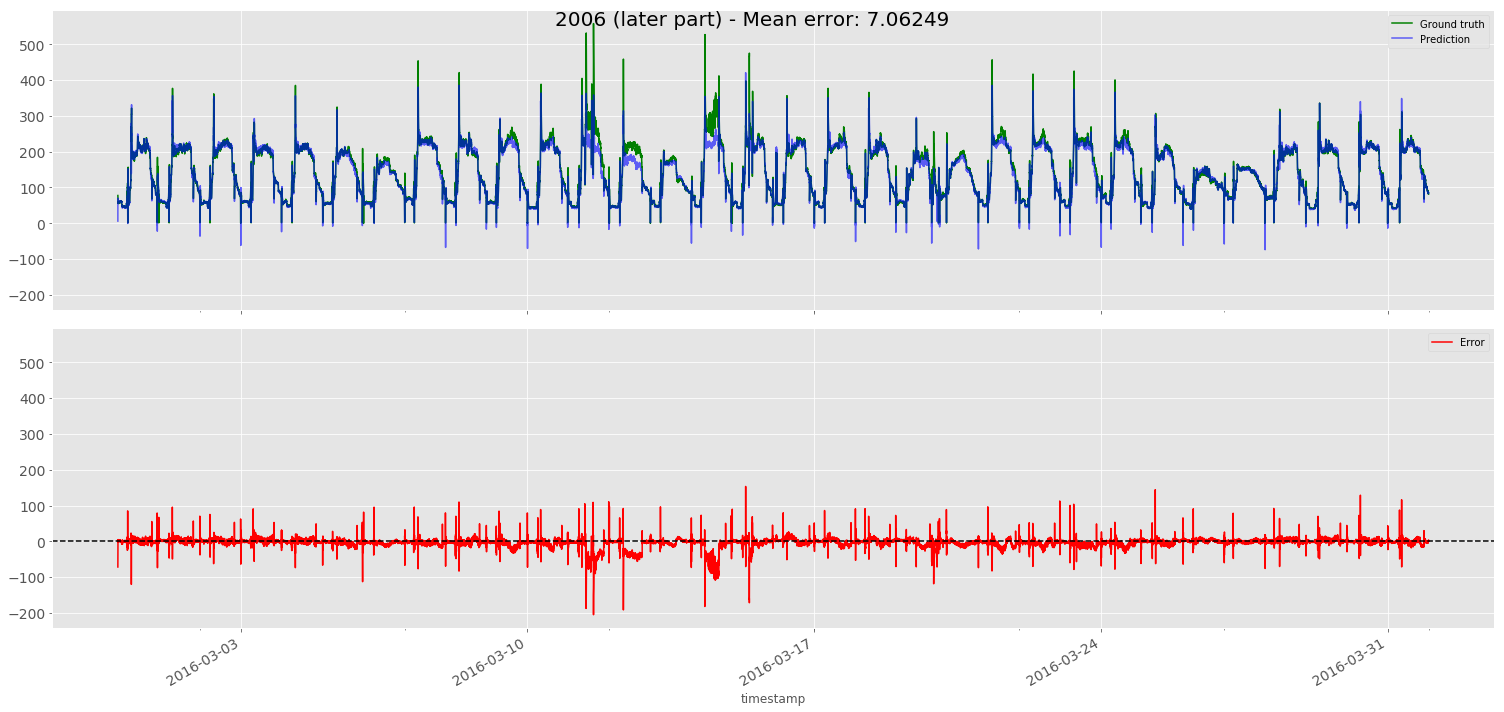

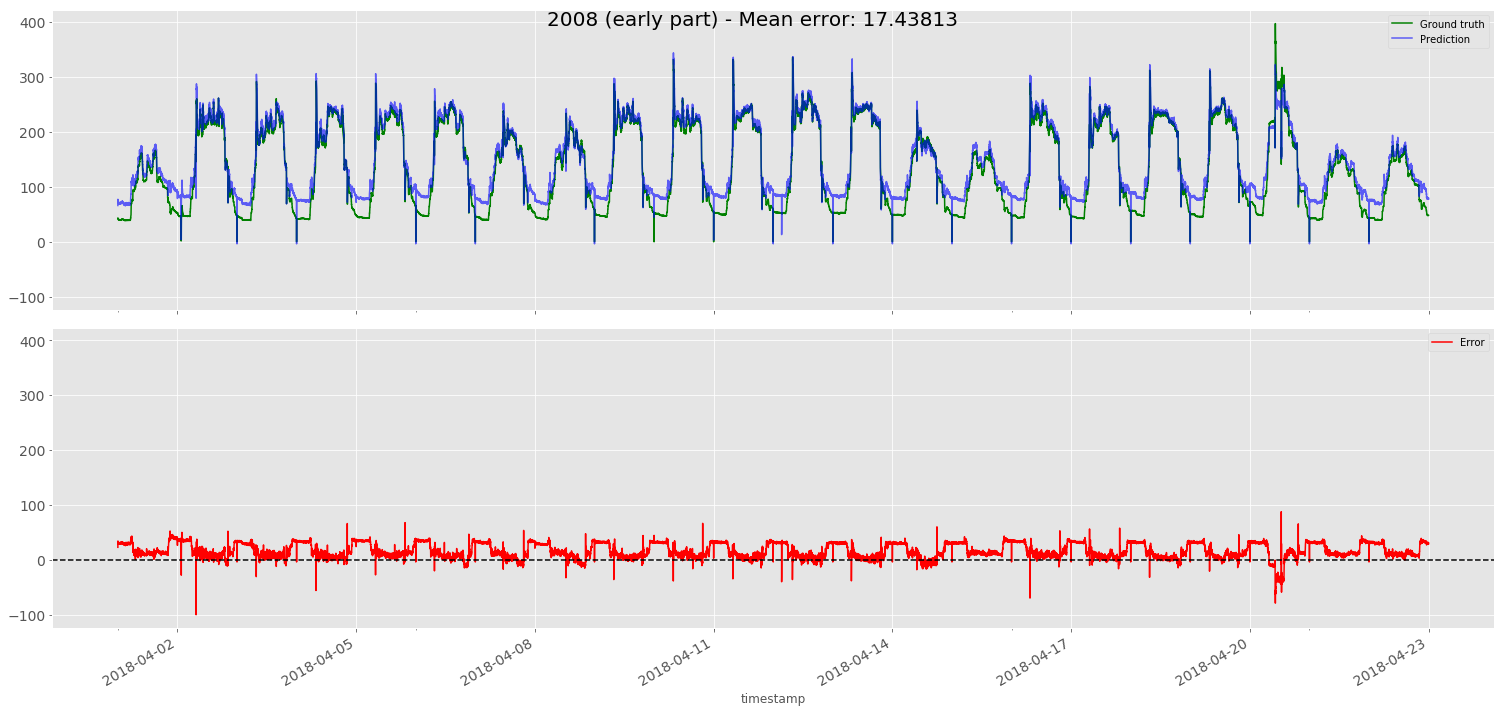

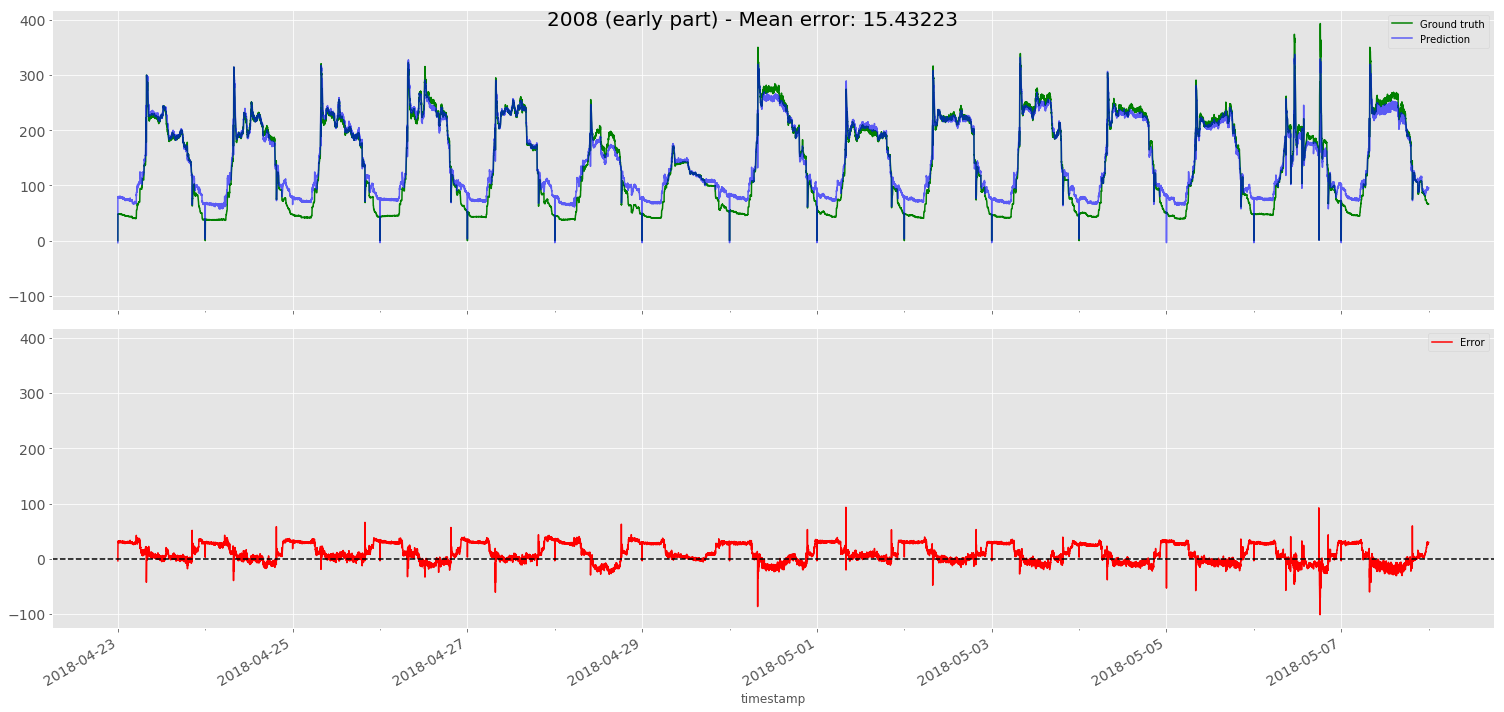

In [131]:
y1_train_pred, _ = gpr.predict(X1_train.values)
y2_train_pred, _ = gpr.predict(X2_train.values)
y1_test_pred, _ = gpr.predict(X1_test.values)
y2_test_pred, _ = gpr.predict(X2_test.values)

plot_model_error(y1_train, y1_train_pred, title="2006 (early part)")
plot_model_error(y1_test, y1_test_pred, title="2006 (later part)")
plot_model_error(y2_train, y2_train_pred, title="2008 (early part)")
plot_model_error(y2_test, y2_test_pred, title="2008 (early part)")

### Plot cumulative error

Target data test error: 9.92222


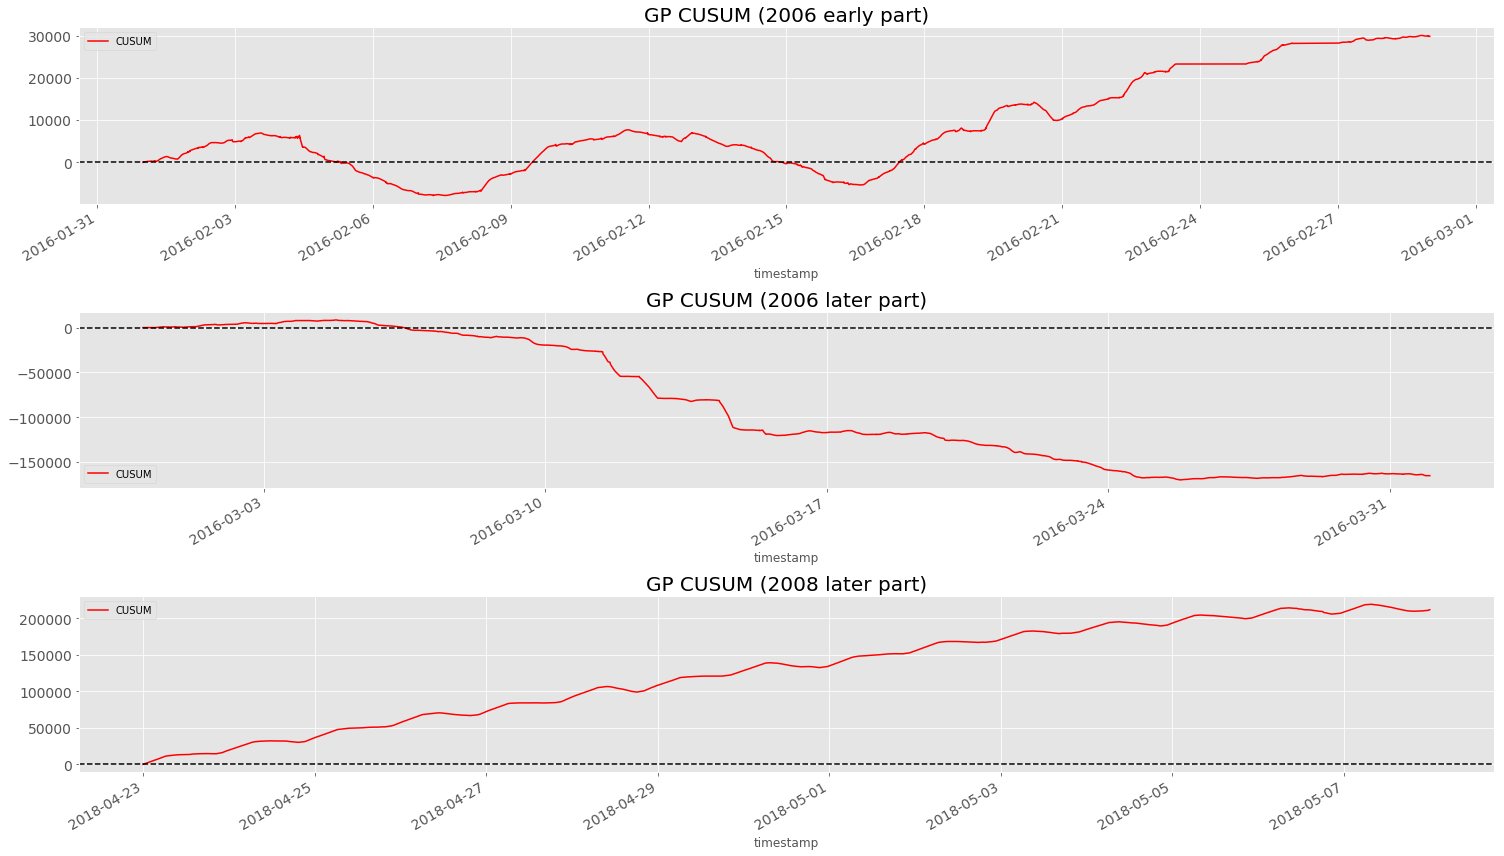

In [132]:
fig, axes = plt.subplots(3, 1, figsize=(21, 12))
plot_cusum(y1_train, y1_train_pred, "GP CUSUM (2006 early part)", ax=axes[0])
plot_cusum(y1_test, y1_test_pred, "GP CUSUM (2006 later part)", ax=axes[1])
plot_cusum(y2_test, y2_test_pred, "GP CUSUM (2008 later part)", ax=axes[2])
print("Target data test error: {:.5f}".format(mean_absolute_error(y2_test, y2_pred)))

Again, just like the linear regression and XGBoost model, we see that the Gaussian Process is also **under predicting** for the 2006 data and **over predicting** for the 2008 data.

However, we should not jump to conclusions here. As mentioned at the top of this document, the predictions are going to be sensitive to hyperparameter settings, so unless we understand the system, we should be careful in our analysis.

## LSTM model

Let's try a simple LSTM model to get a sense of how well a Deep Learning model can do for this problem. But we should note that this <font color="red">**dataset is small**</font>, so the chance of overfitting is very high.

# Distribution of error over time

We analyze the distribution of the error over time to check if there is some systematic errors in the predictions.

In [132]:
# Group error by time and plot box plots
def plot_error_dist(y, pred, figsize=(15, 18), title=None):
    error = y.ravel() - pred.ravel()
    error = pd.Series(error, index=y.index, name="Error")
    df_error = pd.DataFrame(error)
    
    groups = df_error.groupby(error.index.to_series().dt.hour)
    n_groups = len(groups)
    
    # Find nearest square
    n = int(np.sqrt(n_groups) + 1)
    
    fig, ax = plt.subplots(n, n, figsize=figsize, sharex=True, sharey=True)

    if title is None:
        title = "Error distributed by hour"
    fig.suptitle(title)
    groups.boxplot(ax=ax.ravel()[:n_groups]);

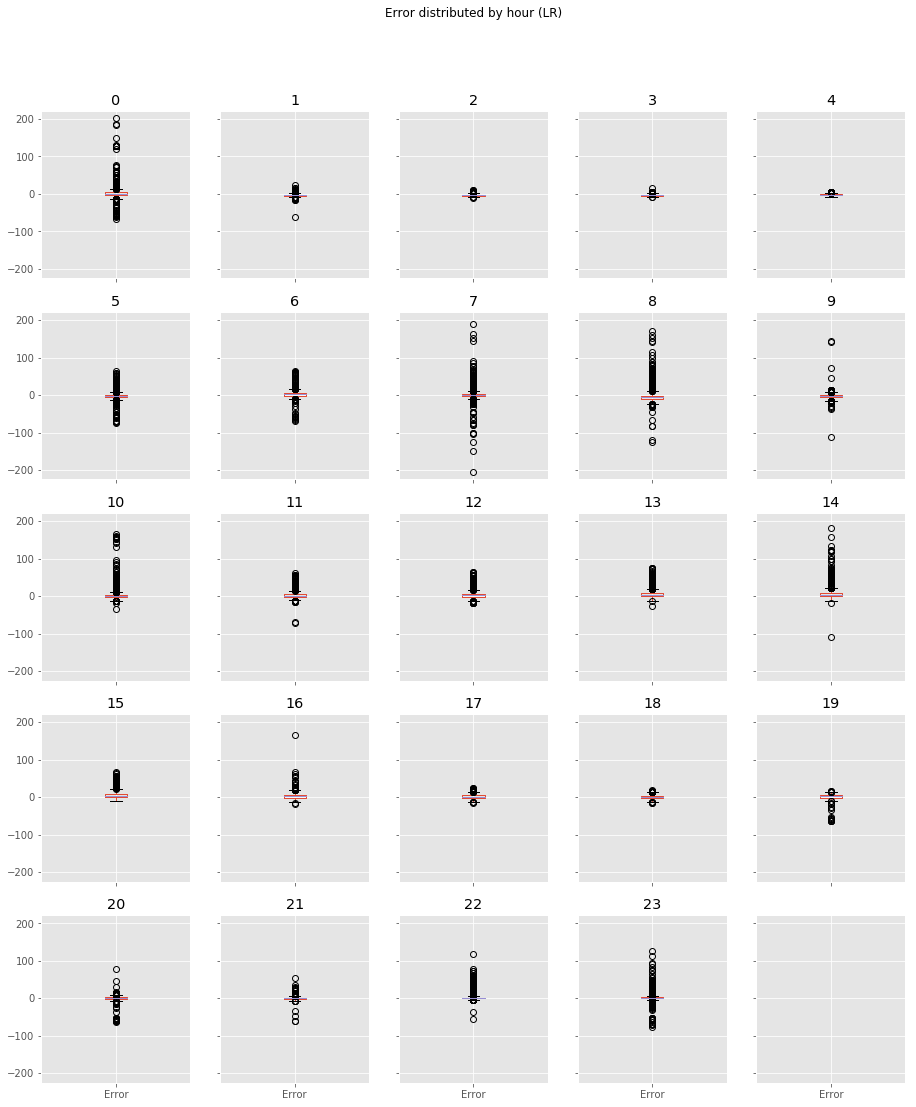

In [137]:
plot_error_dist(y1_test, y1_pred, title="Error distributed by hour (LR)")

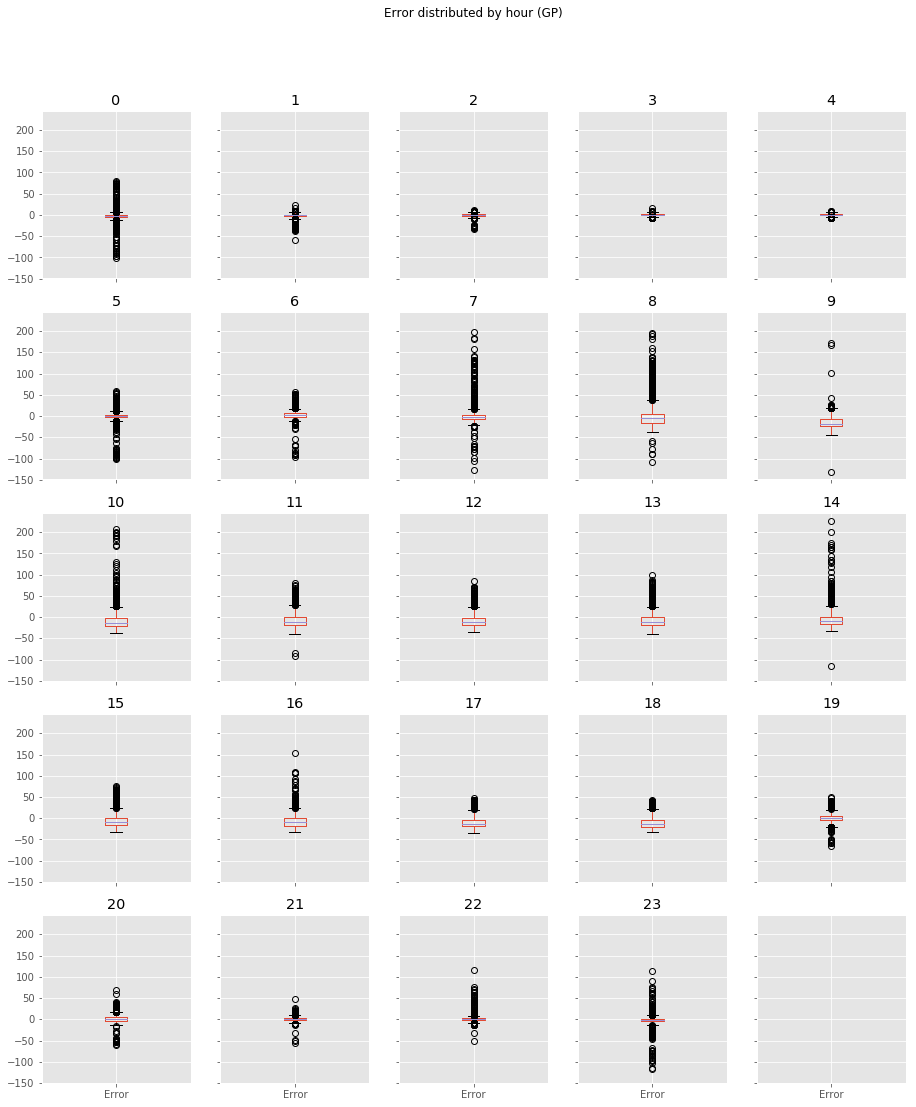

In [133]:
plot_error_dist(y1_test, y1_pred, title="Error distributed by hour (GP)")

---

# Miscellaneous

Code no longer used

Best param: 27.825594022071257


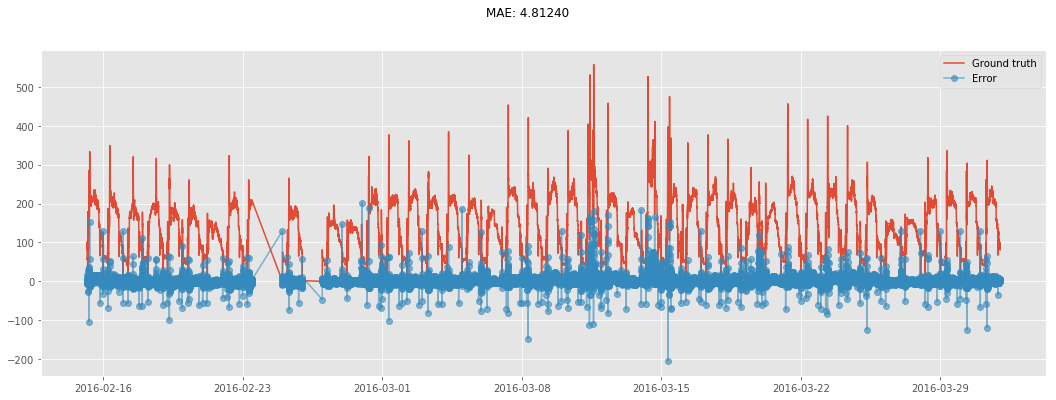

In [240]:
alphas = np.logspace(-3, 5, 10)
ridge_cv = RidgeCV(alphas=alphas, cv=TimeSeriesSplit(n_splits=3))
ridge_cv.fit(X1_train, y1_train)
print("Best param: {}".format(ridge_cv.alpha_))

y1_pred = ridge_cv.predict(X1_test)

mean_error = mean_absolute_error(y1_test, y1_pred)

plt.figure(figsize=(18, 6))
plt.plot(y1_test, label="Ground truth")
plt.plot(y1_test - y1_pred, marker='o', alpha=0.6, label="Error")
plt.legend()
plt.suptitle("MAE: {:.5f}".format(mean_error));

In [206]:
y2_pred = ridge_cv.predict(X2_test)
mean_absolute_error(y2_test, y2_pred)

7.733407180798312

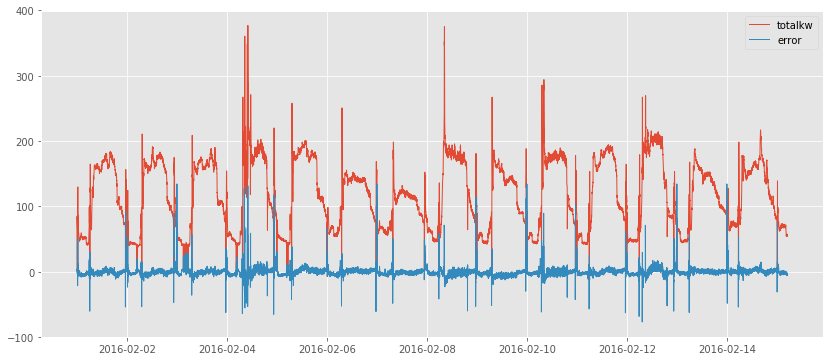

In [136]:
y1_pred = ridge.predict(df1_train)

plt.figure(figsize=(14, 6))
plt.plot(df1_train.index, y1_train, linewidth=1, label="totalkw")
plt.plot(df1_train.index, y1_train - y1_pred, linewidth=1, label="error")
plt.legend()

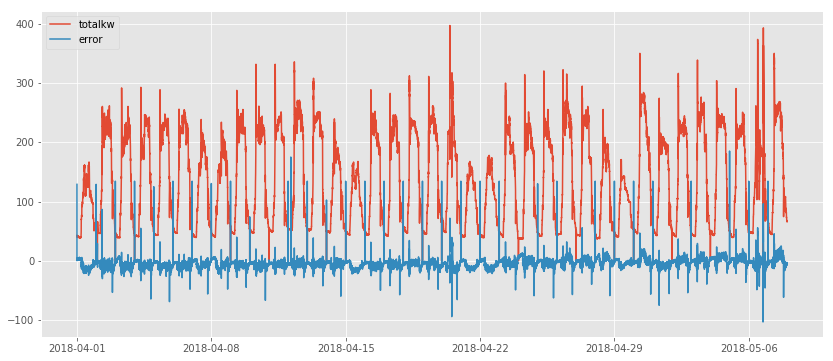

In [137]:
y2_pred = ridge.predict(dfX2)

plt.figure(figsize=(14, 6))
plt.plot(dfX2.index, y2, label="totalkw")
plt.plot(dfX2.index, y2 - y2_pred, label="error")
plt.legend()

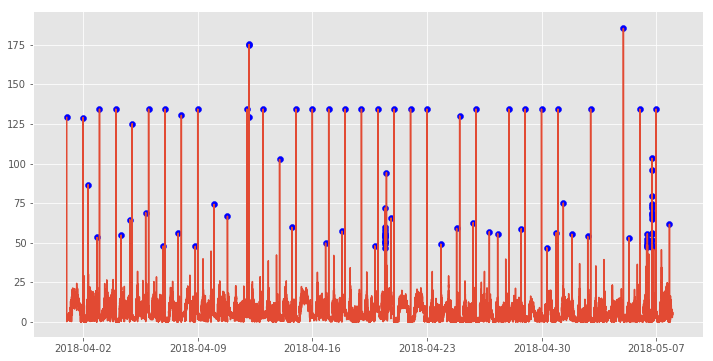

In [174]:
error = np.abs(y2 - y2_pred)
large_errors_idxs = np.argwhere(error > np.max(error) / 4)

plt.figure(figsize=(12, 6))
plt.plot(dfX2.index, error)
plt.scatter(dfX2.index[large_errors_idxs], error[large_errors_idxs], c='blue')

In [194]:
large_errors_times = df2.index[large_errors_idxs]
large_errors = error[large_errors_idxs]

tmp = pd.DataFrame(data=[large_errors_times.flatten(), 
                         large_errors.flatten()]).T
tmp.columns = ["time", "error"]
tmp = tmp.set_index("time")
tmp.index = tmp.index.floor("1H").strftime("%a-%H")
tmp

,error
Sun-00,129.055
Mon-00,129.035
Mon-07,86.7322
Mon-20,53.3341
Tue-00,134.372
Wed-00,134.372
Wed-07,54.8495
Wed-20,64.5326
Thu-00,125.151
Thu-19,68.9725


In [195]:
bad_times = pd.DataFrame(data=large_errors_times, columns=["time"])

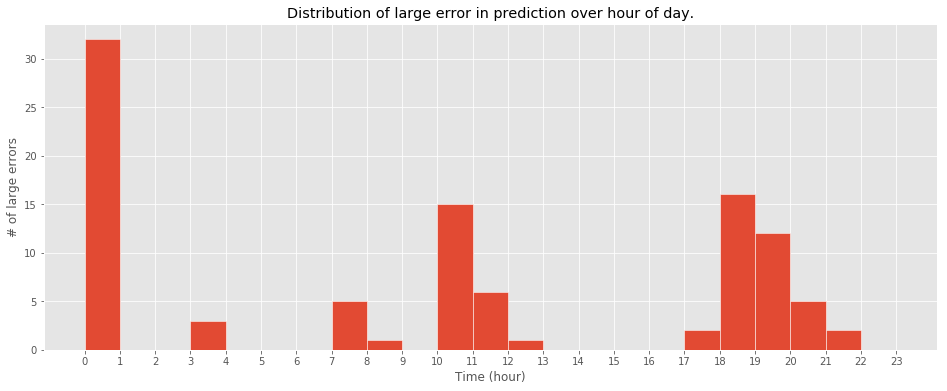

In [196]:
plt.figure(figsize=(16, 6))
bad_times.time.dt.hour.hist(bins=range(24), edgecolor="white")
plt.xlabel("Time (hour)")
plt.ylabel("# of large errors")
plt.title("Distribution of large error in prediction over hour of day.")
plt.xticks(range(24));

In [233]:
bad_times.time.dtype

dtype('<M8[ns]')

In [ ]:
# Group by hour of day and plot boxplot



In [198]:
isinstance(tmp, pd.DataFrame)

True

In [258]:
def plot_errors(y_true, y_pred, time_index):
#     print(y_true.shape, y_pred.shape)
    errors = y_true - y_pred
    
    df = pd.DataFrame(data=errors)
#     df.index = df.index.floor("1H").strftime("%a-%H")
    
    assert(len(y_true) == len(time_index))
    
    df.boxplot(by=time_index)
    
    return df
        
    

In [253]:
dfX2.index.to_series().dt.hour.values

array([ 0,  0,  0, ..., 23, 23, 23])

In [259]:
df_errors = plot_errors(y2, y2_pred, dfX2.index.to_series().dt.hour)
# df_errors.index

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [240]:
bad_times.time.dtype

dtype('<M8[ns]')

In [243]:
bad_times.time.dtype

dtype('<M8[ns]')

In [245]:
bad_times.time[:3]

0   2018-04-01 00:00:00
1   2018-04-02 00:00:00
2   2018-04-02 07:31:00
Name: time, dtype: datetime64[ns]

In [244]:
df_errors.index[:3]

DatetimeIndex(['2018-04-01 00:00:00', '2018-04-01 00:01:00',
               '2018-04-01 00:02:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [246]:
df_errors.index.dt.hour

AttributeError: 'DatetimeIndex' object has no attribute 'dt'